In [69]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn import metrics as skmetrics
import seaborn as sns; sns.set()
import scipy.stats

In [70]:
pd.set_option('display.max_rows', 5000)
pd.reset_option('display.max_rows')

## Model 1 evaluation

In [71]:
df = pd.read_csv('~/personality-normalized-word2vec-lema.csv', encoding='utf-8')
df.shape

(1039, 186)

In [72]:
liwc_attr = ['X26humans','X4i','X8they','X27affect','X9ipron','X3ppron','X28posemo','X41excl','X12auxverb','X19negate','X15future','X39inhib','X50ingest','X20quant','X13past','X51relativ','X29negemo','X21number','X47body','X60relig','X56achieve','X24family','X42percept','X31anger','X37tentat','X25friend','X57leisure','X43see','X34insight','X5we','X22swear','X62assent','X64filler']

In [73]:
df = df.convert_objects(convert_numeric=True)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [74]:
psico = pd.read_csv('/home/bahbbc/Downloads/psycholinguistic_properties/BP.csv', encoding='utf-8')

In [75]:
psico.head()

,Word,Simplified grammatical category,Concretenes,Subjective Frequency,Imagery,AoA,Log frequency,Frequency
0,abafado,a,3.47,3.92,3.96,5.28,7.11,1220.0
1,abafador,a,5.73,2.84,5.10,7.25,4.41,82.0
2,abalado,a,2.61,4.12,3.59,7.62,8.15,3450.0
3,abalizado,a,3.88,2.58,3.56,7.59,4.36,78.0
4,abandonado,a,3.68,4.16,3.97,5.24,9.75,17183.0


In [76]:
concreteness = dict(zip(psico.Word, psico.Concretenes))
subjective_freq = dict(zip(psico.Word, psico['Subjective Frequency']))
imagery = dict(zip(psico.Word, psico.Imagery))
aoa =  dict(zip(psico.Word, psico.AoA))
log_freq = dict(zip(psico.Word, psico['Log frequency']))
freq = dict(zip(psico.Word, psico.Frequency))

In [77]:
df.extraversion_m.value_counts()

0    529
1    510
Name: extraversion_m, dtype: int64

In [78]:
train_w2v_data, test_w2v_data = train_test_split(df, test_size=0.3, random_state=42)

In [79]:
def remove_nan(atributes):
    train_attr = np.array(train_w2v_data[atributes])
    test_attr = np.array(test_w2v_data[atributes])
    train_attr[np.isnan(train_attr)] = 0
    test_attr[np.isnan(test_attr)] = 0
    return (train_attr, test_attr)

In [80]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['extraversion_m']
    evaluate_prediction(predictions, target)

In [81]:
def makeFeatureVec(words, psico_dict):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = 0.
    #
    nwords = 0.
    
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if (word in psico_dict):
            nwords = nwords + 1.
            featureVec = featureVec + psico_dict[word]
    # 
    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = featureVec / nwords
    else:
        print 'sorry, empty...'
    return featureVec


def getAvgFeatureVecs(reviews, psico_dict):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews)),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
        #Print a status message every 1000th review
        if counter%100. == 0.:
            print "Review %d of %d" % (counter, len(reviews))
        #Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, psico_dict)
        #Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [82]:
def w2v_tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            word = word.lower()
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [83]:
train, test = remove_nan(liwc_attr)

In [84]:
test_tokenized = test_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [85]:
index = pd.isnull(train_w2v_data.formatted_text)
train_w2v_data.loc[index, 'formatted_text'] = ''

In [86]:
concreteness = dict(zip(psico.Word, psico.Concretenes))
subjective_freq = dict(zip(psico.Word, psico['Subjective Frequency']))
imagery = dict(zip(psico.Word, psico.Imagery))
aoa =  dict(zip(psico.Word, psico.AoA))
log_freq = dict(zip(psico.Word, psico['Log frequency']))
freq = dict(zip(psico.Word, psico.Frequency))

In [87]:
conc_trainDataVecs = getAvgFeatureVecs( train_tokenized, concreteness )
conc_testDataVecs = getAvgFeatureVecs( test_tokenized, concreteness )
ima_trainDataVecs = getAvgFeatureVecs( train_tokenized, imagery )
ima_testDataVecs = getAvgFeatureVecs( test_tokenized, imagery )
aoa_trainDataVecs = getAvgFeatureVecs( train_tokenized, aoa )
aoa_testDataVecs = getAvgFeatureVecs( test_tokenized, aoa )

Review 0 of 727
sorry, empty...
Review 100 of 727
sorry, empty...
Review 200 of 727
sorry, empty...
sorry, empty...
Review 300 of 727
sorry, empty...
Review 400 of 727
sorry, empty...
sorry, empty...
Review 500 of 727
Review 600 of 727
sorry, empty...
sorry, empty...
Review 700 of 727
Review 0 of 312
sorry, empty...
Review 100 of 312
sorry, empty...
sorry, empty...
sorry, empty...
Review 200 of 312
sorry, empty...
sorry, empty...
Review 300 of 312
Review 0 of 727
sorry, empty...
Review 100 of 727
sorry, empty...
Review 200 of 727
sorry, empty...
sorry, empty...
Review 300 of 727
sorry, empty...
Review 400 of 727
sorry, empty...
sorry, empty...
Review 500 of 727
Review 600 of 727
sorry, empty...
sorry, empty...
Review 700 of 727
Review 0 of 312
sorry, empty...
Review 100 of 312
sorry, empty...
sorry, empty...
sorry, empty...
Review 200 of 312
sorry, empty...
sorry, empty...
Review 300 of 312
Review 0 of 727
sorry, empty...
Review 100 of 727
sorry, empty...
Review 200 of 727
sorry, empty

In [88]:
train_data = np.vstack((conc_trainDataVecs, ima_trainDataVecs, aoa_trainDataVecs))

In [89]:
train_data = train_data.T
train_data = pd.DataFrame(train_data, index=train_w2v_data.index, columns=['concreteness', 'imagery', 'aoa'])
train = pd.DataFrame(train, index=train_w2v_data.index, columns=liwc_attr)

In [90]:
train_features = pd.concat([train_data, train], axis=1)

In [91]:
test_data = np.vstack((conc_testDataVecs, ima_testDataVecs, aoa_testDataVecs))

In [92]:
test_data = test_data.T
test_data = pd.DataFrame(test_data, index=test_w2v_data.index, columns=['concreteness', 'imagery', 'aoa'])
test = pd.DataFrame(test, index=test_w2v_data.index, columns=liwc_attr)

In [93]:
test_features = pd.concat([test_data, test], axis=1)

# Correlation heatmap

In [94]:
correlation_attr = train_features.append(test_features)

extr = train_w2v_data.extraversion.append(test_w2v_data.extraversion)
agre = train_w2v_data.agreeableness.append(test_w2v_data.agreeableness)
cons = train_w2v_data.conscientiousness.append(test_w2v_data.conscientiousness)
neur = train_w2v_data.neuroticism.append(test_w2v_data.neuroticism)
openn = train_w2v_data.openness.append(test_w2v_data.openness)

personality_data = pd.DataFrame({'extr': extr, 'agre':agre, 'cons':cons, 'neur':neur, 'open':openn})

correlation_attr = pd.concat([correlation_attr, personality_data], axis=1)

In [95]:
corr = correlation_attr.corr()

In [96]:
corr['extr'][abs(corr['extr']) > 0.2]

X28posemo    0.218339
X24family    0.200734
extr         1.000000
open         0.215956
Name: extr, dtype: float64

In [97]:
corr['agre'][abs(corr['agre']) > 0.15]

X27affect    0.150022
X28posemo    0.194398
agre         1.000000
cons         0.184472
extr         0.193474
neur        -0.348070
Name: agre, dtype: float64

In [98]:
corr['cons'][abs(corr['cons']) > 0.15]

X28posemo    0.181192
agre         0.184472
cons         1.000000
extr         0.155086
Name: cons, dtype: float64

In [99]:
corr['neur'][abs(corr['neur']) > 0.15]

X4i     0.172642
agre   -0.348070
extr   -0.163381
neur    1.000000
Name: neur, dtype: float64

In [100]:
corr['open'][abs(corr['open']) > 0.15]

extr    0.215956
open    1.000000
Name: open, dtype: float64

In [101]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

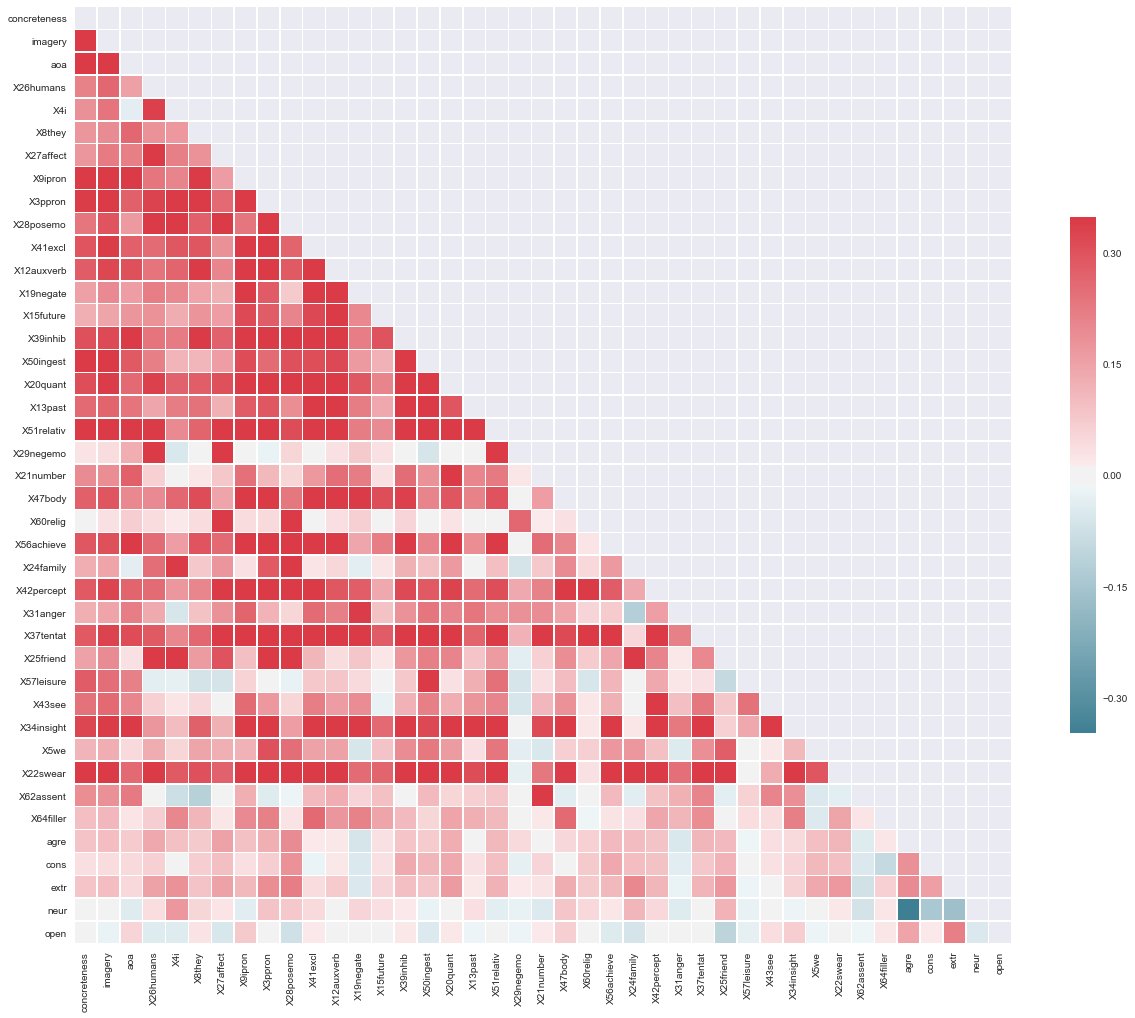

In [102]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib

force = False
model_trainer = RandomizedSearchCV(
    n_iter=1, 
    estimator=DecisionTreeRegressor(),
    param_distributions={
        "max_features": ["log2"],
        "random_state": [42],
        "criterion":['mse']
    },
    verbose=True,
    refit=True,
    cv=10,
    n_jobs=-1
)

## Extraversion

In [105]:
%%time
model_trainer.fit(train_features, train_w2v_data['extraversion'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


CPU times: user 170 ms, sys: 55.7 ms, total: 226 ms
Wall time: 427 ms


In [106]:
yp = model.predict(test_features)
yt = test_w2v_data['extraversion']

In [107]:
skmetrics.mean_squared_error(yt, yp)

1.304598717948718

In [108]:
skmetrics.r2_score(yt, yp)

-0.81530346924329344

In [109]:
skmetrics.mean_squared_error(yt, yp)**0.5

1.1421903159932314

In [110]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.0719, 'X28posemo'), (0.0692, 'aoa'), (0.0644, 'X20quant'), (0.0511, 'X19negate'), (0.0462, 'X24family'), (0.0454, 'X41excl'), (0.0451, 'X26humans'), (0.0419, 'X47body'), (0.0373, 'X56achieve'), (0.0337, 'X8they'), (0.0336, 'X31anger'), (0.0334, 'X15future'), (0.0322, 'concreteness'), (0.0244, 'X9ipron'), (0.024, 'X13past'), (0.0232, 'X21number'), (0.0227, 'X29negemo'), (0.0223, 'X43see'), (0.0221, 'X50ingest'), (0.0219, 'X62assent'), (0.0215, 'X22swear'), (0.0209, 'X25friend'), (0.0207, 'X60relig'), (0.0202, 'X51relativ'), (0.0193, 'X12auxverb'), (0.018, 'X37tentat'), (0.017, 'X39inhib'), (0.0164, 'X64filler'), (0.0139, 'X3ppron'), (0.0138, 'X34insight'), (0.0122, 'X4i'), (0.0109, 'X57leisure'), (0.0104, 'X5we'), (0.01, 'X27affect'), (0.0064, 'imagery'), (0.0023, 'X42percept')]


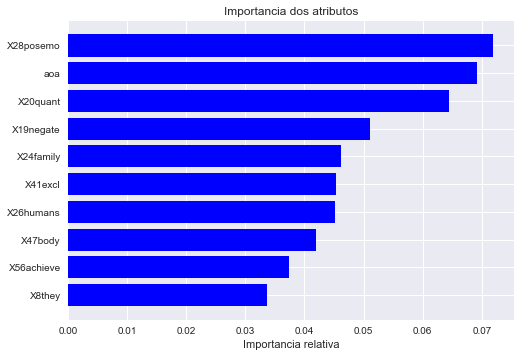

In [111]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()

## Agreableness

In [112]:
%%time
model_trainer.fit(train_features, train_w2v_data['agreeableness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 180 ms, sys: 93.6 ms, total: 273 ms
Wall time: 304 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [113]:
yp = model.predict(test_features)
yt = test_w2v_data['agreeableness']

In [114]:
skmetrics.mean_squared_error(yt, yp)

0.60247997784108898

In [115]:
skmetrics.r2_score(yt, yp)

-0.79736804754274959

In [116]:
skmetrics.mean_squared_error(yt, yp)**0.5

0.77619583729951103

In [117]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.0603, 'X56achieve'), (0.0564, 'X22swear'), (0.0551, 'X28posemo'), (0.046, 'X29negemo'), (0.0446, 'X13past'), (0.0421, 'X8they'), (0.0408, 'X9ipron'), (0.0398, 'concreteness'), (0.0383, 'X12auxverb'), (0.0349, 'aoa'), (0.0334, 'X27affect'), (0.0323, 'X4i'), (0.0299, 'X50ingest'), (0.029, 'X19negate'), (0.0278, 'X41excl'), (0.0274, 'X42percept'), (0.0272, 'X26humans'), (0.0264, 'X39inhib'), (0.0241, 'X20quant'), (0.0237, 'X51relativ'), (0.0236, 'X47body'), (0.0222, 'X64filler'), (0.0214, 'X43see'), (0.0212, 'X57leisure'), (0.0209, 'X34insight'), (0.0204, 'X21number'), (0.0196, 'X62assent'), (0.0174, 'X5we'), (0.0164, 'imagery'), (0.016, 'X60relig'), (0.0159, 'X25friend'), (0.013, 'X3ppron'), (0.0101, 'X31anger'), (0.0095, 'X37tentat'), (0.0093, 'X24family'), (0.0039, 'X15future')]


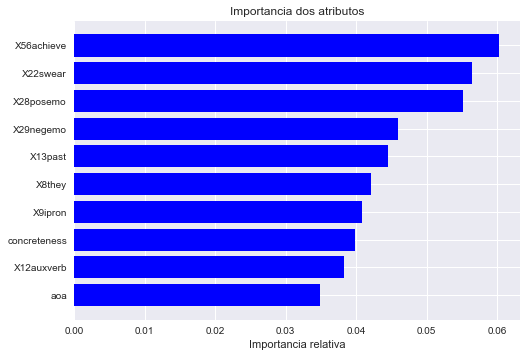

In [118]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()

## Conscientiousness

In [119]:
%%time
model_trainer.fit(train_features, train_w2v_data['conscientiousness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 192 ms, sys: 98 ms, total: 290 ms
Wall time: 377 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [120]:
yp = model.predict(test_features)
yt = test_w2v_data['conscientiousness']

In [121]:
skmetrics.mean_squared_error(yt, yp)

0.82751544792655918

In [122]:
skmetrics.r2_score(yt, yp)

-1.1508336984634817

In [123]:
skmetrics.mean_squared_error(yt, yp)**0.5

0.9096787608417376

In [124]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.0697, 'X56achieve'), (0.0574, 'X60relig'), (0.0562, 'X3ppron'), (0.0521, 'X15future'), (0.0448, 'X50ingest'), (0.0385, 'X24family'), (0.0383, 'X26humans'), (0.0361, 'X47body'), (0.0354, 'X9ipron'), (0.0348, 'X12auxverb'), (0.0347, 'concreteness'), (0.0333, 'X41excl'), (0.0314, 'X39inhib'), (0.0294, 'X25friend'), (0.0279, 'X42percept'), (0.0256, 'X57leisure'), (0.0242, 'X29negemo'), (0.0241, 'X31anger'), (0.0231, 'X64filler'), (0.022, 'aoa'), (0.022, 'X20quant'), (0.02, 'X4i'), (0.0191, 'X43see'), (0.0186, 'X62assent'), (0.0183, 'X28posemo'), (0.0176, 'X13past'), (0.0173, 'X51relativ'), (0.0171, 'X27affect'), (0.017, 'X5we'), (0.0164, 'X22swear'), (0.016, 'X37tentat'), (0.0156, 'X8they'), (0.0134, 'X21number'), (0.0129, 'imagery'), (0.0104, 'X19negate'), (0.0094, 'X34insight')]


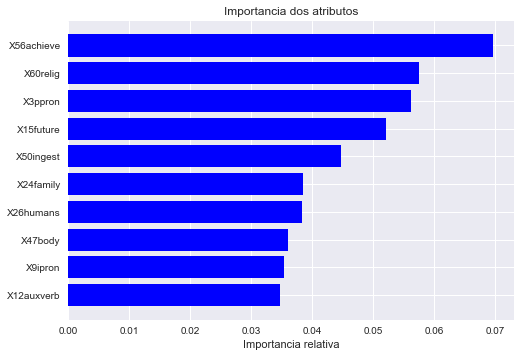

In [125]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()

## Neuroticism

In [126]:
%%time
model_trainer.fit(train_features, train_w2v_data['neuroticism'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 161 ms, sys: 78.2 ms, total: 240 ms
Wall time: 308 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [127]:
yp = model.predict(test_features)
yt = test_w2v_data['neuroticism']

In [128]:
skmetrics.mean_squared_error(yt, yp)

1.378278205128205

In [129]:
skmetrics.r2_score(yt, yp)

-0.97949747119032238

In [130]:
skmetrics.mean_squared_error(yt, yp)**0.5

1.17400093915133

In [131]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.0788, 'X4i'), (0.0572, 'X60relig'), (0.0436, 'X57leisure'), (0.0422, 'X51relativ'), (0.0419, 'X28posemo'), (0.041, 'X19negate'), (0.0392, 'X22swear'), (0.0383, 'imagery'), (0.0346, 'concreteness'), (0.0345, 'X3ppron'), (0.0336, 'X42percept'), (0.0333, 'X29negemo'), (0.0331, 'X56achieve'), (0.0297, 'X50ingest'), (0.0292, 'X41excl'), (0.0281, 'X31anger'), (0.0267, 'X37tentat'), (0.026, 'X34insight'), (0.0247, 'X8they'), (0.0236, 'X13past'), (0.0227, 'X20quant'), (0.0222, 'X15future'), (0.0209, 'X24family'), (0.0193, 'X62assent'), (0.0189, 'aoa'), (0.0188, 'X25friend'), (0.0186, 'X47body'), (0.0168, 'X43see'), (0.0168, 'X27affect'), (0.0166, 'X64filler'), (0.0163, 'X39inhib'), (0.0146, 'X9ipron'), (0.0146, 'X26humans'), (0.0135, 'X12auxverb'), (0.0064, 'X5we'), (0.0039, 'X21number')]


In [132]:
importances[indices][-10:]

array([ 0.03479752,  0.03535419,  0.03608662,  0.03829181,  0.03853807,
        0.04480789,  0.05211907,  0.05617184,  0.05743644,  0.0696569 ])

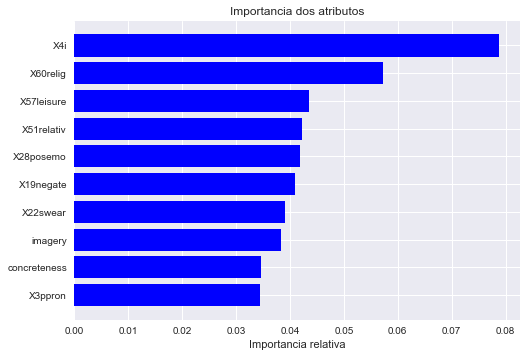

In [133]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
plt.xlabel('Importancia relativa')
plt.show()

## Openess

In [134]:
%%time
model_trainer.fit(train_features, train_w2v_data['openness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 184 ms, sys: 73.9 ms, total: 257 ms
Wall time: 350 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [135]:
yp = model.predict(test_features)
yt = test_w2v_data['openness']

In [136]:
skmetrics.mean_squared_error(yt, yp)

0.81781220322886983

In [137]:
skmetrics.r2_score(yt, yp)

-1.2437970371489429

In [138]:
skmetrics.mean_squared_error(yt, yp)**0.5

0.90432969830082977

In [139]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.066, 'aoa'), (0.0505, 'X34insight'), (0.044, 'X25friend'), (0.0387, 'X27affect'), (0.0385, 'X3ppron'), (0.0379, 'X8they'), (0.0375, 'X12auxverb'), (0.0374, 'X4i'), (0.0372, 'imagery'), (0.0368, 'X26humans'), (0.0365, 'X28posemo'), (0.0362, 'X37tentat'), (0.0349, 'X15future'), (0.0344, 'X42percept'), (0.0324, 'X62assent'), (0.0291, 'X21number'), (0.0261, 'X20quant'), (0.0255, 'X51relativ'), (0.0255, 'X13past'), (0.0239, 'X39inhib'), (0.0231, 'X56achieve'), (0.0221, 'X31anger'), (0.0215, 'X24family'), (0.0211, 'concreteness'), (0.0211, 'X47body'), (0.0206, 'X9ipron'), (0.0188, 'X19negate'), (0.0185, 'X43see'), (0.0182, 'X41excl'), (0.015, 'X22swear'), (0.0145, 'X50ingest'), (0.0139, 'X57leisure'), (0.0137, 'X5we'), (0.0125, 'X29negemo'), (0.0096, 'X64filler'), (0.0068, 'X60relig')]


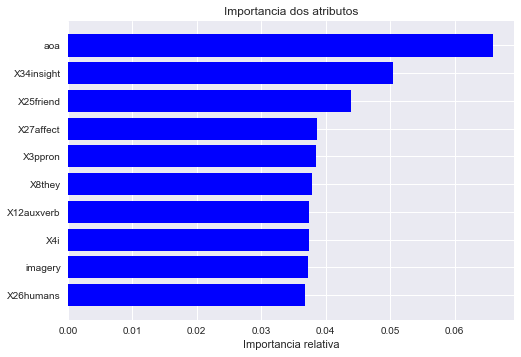

In [140]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()